# APA Laboratori 7  - SVMs 

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade 
# !pip install numpy --upgrade
# !pip install scipy --upgrade
# !pip install statsmodels --upgrade
# !pip install scikit-learn --upgrade
%load_ext autoreload

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
from numpy.random import uniform, normal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.random.seed(7)

## Modelling artificial 2D sinusoidal data for two-class problems

First we create a simple two-class data set:

In [3]:
N = 200

def make_sinusoidals(m,noise=0.2):
  x1 = np.ones(2*m)
  x2 = np.ones(2*m)
  
  for i in range(m):
    x1[i] = (i/m) * np.pi
    x2[i] = np.sin(x1[i]) + normal(0,noise,1)
  
  
  for j in range(m): 
    x1[m+j] = (j/m + 1/2) * np.pi
    x2[m+j] = np.cos(x1[m+j]) + normal(0,noise,1)
  
  
  target = [1]*m+[-1]*m
  
  return pd.DataFrame({'x1':x1,'x2':x2,'t':target})


 let's generate the data

In [4]:
dataset = make_sinusoidals(N)

and have a look at it

In [5]:
dataset.describe()

,x1,x2,t
count,400.000000,400.000000,400.000000
mean,2.348341,-0.010011,0.000000
std,1.201209,0.739437,1.001252
min,0.000000,-1.401917,-1.000000
25%,1.566869,-0.674809,-1.000000
50%,2.348341,-0.040117,0.000000
75%,3.129812,0.676608,1.000000
max,4.696681,1.450016,1.000000


<IPython.core.display.Javascript object>


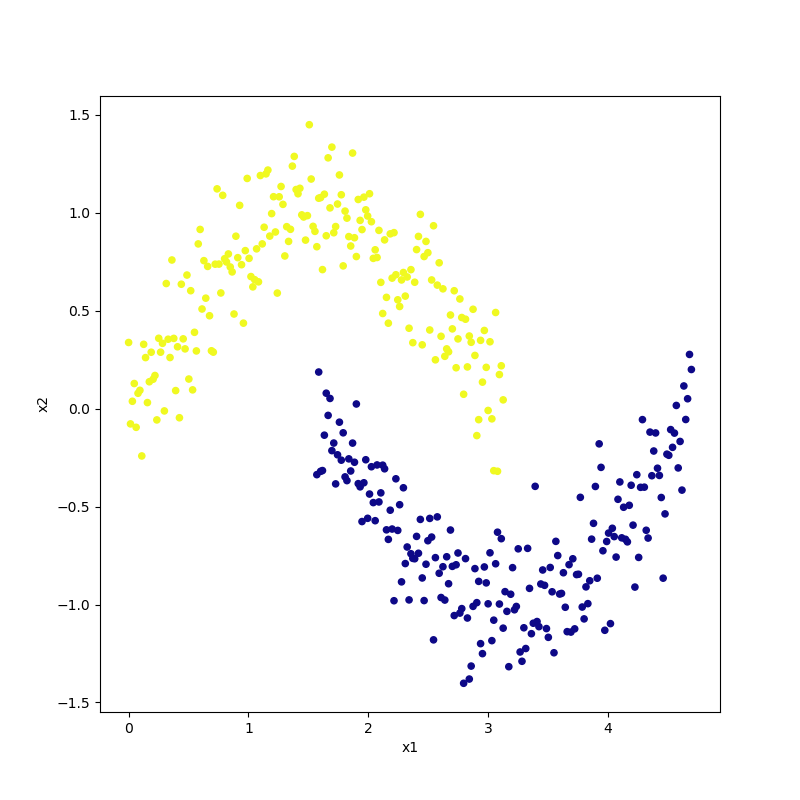

In [6]:
dataset.plot.scatter(x='x1', y='x2', c='t', colormap='plasma',figsize=(8,8),colorbar=False);

Now we wish to fit and visualize different SVM models

### model 1: LINEAR kernel, C=1 (cost parameter)

In [7]:
from sklearn.svm import SVC

svc = SVC(C=1, kernel='linear')
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [26 25]


 Now we are going to visualize what we have done; since we have artificial data, instead of creating
 a random test set, we can create a grid of points as test

In [8]:
def plot_prediction(model, model_name, resol=200, ax=None):
    x_min, x_max = dataset.x1.min(), dataset.x1.max()
    y_min, y_max = dataset.x2.min(), dataset.x2.max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resol),
                         np.linspace(y_min, y_max, resol))
    
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn, extent=[x_min, x_max, y_min,y_max])
    dataset.plot.scatter(x='x1', y='x2', c='t', colormap='plasma',colorbar=False,ax=ax,title=model_name+', supp=%d'%np.sum(model.n_support_))
    dataset.iloc[model.support_].plot.scatter(x='x1', y='x2', c='t', colormap='bwr',colorbar=False,ax=ax,marker='x',s=40)
    CS=ax.contour(xx, yy, Z, levels=[-1,0,1],colors=['grey','black','grey'])
    plt.clabel(CS, inline=1, fontsize=10)


<div class="alert alert-block alert-info"> make sure you understand the following results (one by one and their differences)</div>

plot the data, the OSH with margins, the support vectors, ...

<IPython.core.display.Javascript object>


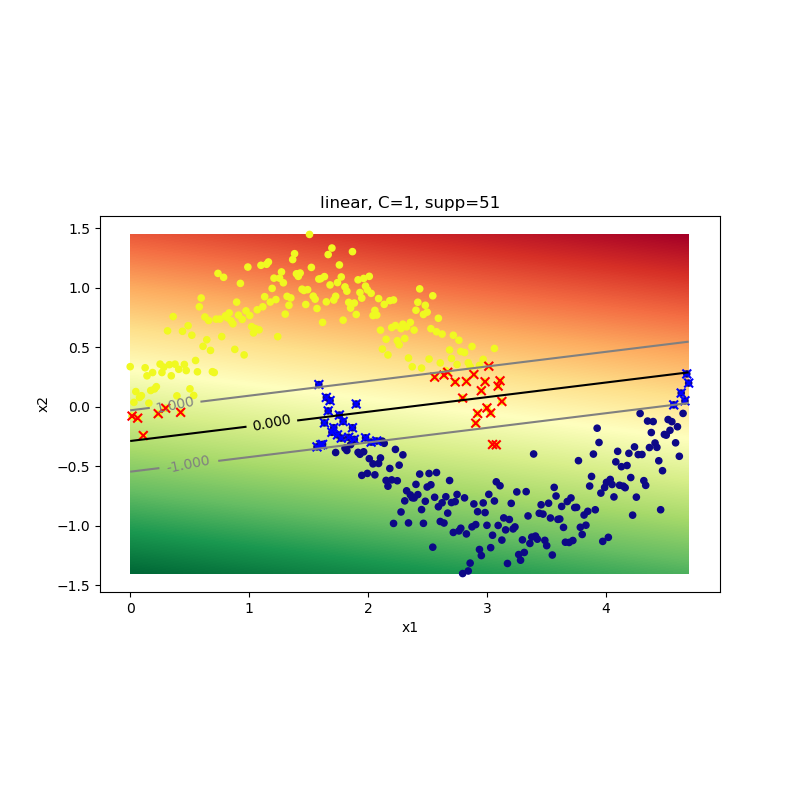

In [9]:
plot_prediction(svc, 'linear, C=1')

 ### model 2: linear kernel, C=0.1 (cost parameter)

In [10]:
svc = SVC(C=0.1, kernel='linear')
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [49 48]


<IPython.core.display.Javascript object>


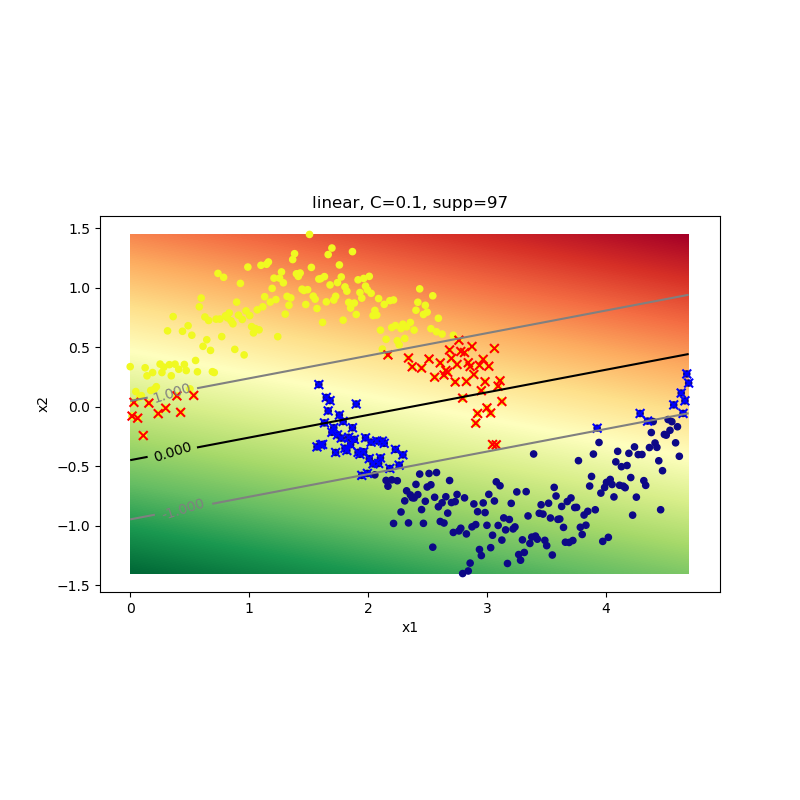

In [11]:
plot_prediction(svc, 'linear, C=0.1')

the margin is wider (lower VC dimension), number of support vectors is larger (more violations of the margin)

### model 3: linear kernel, C=25 (cost parameter)

In [12]:
svc = SVC(C=25, kernel='linear')
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [18 18]


<IPython.core.display.Javascript object>


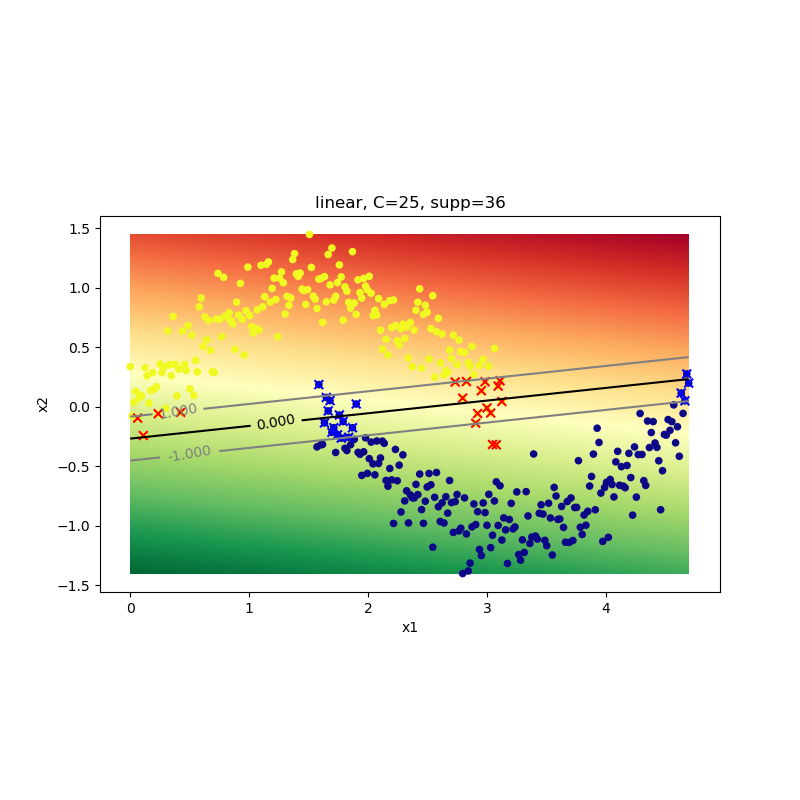

In [13]:
plot_prediction(svc, 'linear, C=25')

the margin is narrower (higher VC dimension), number of support vectors is smaller (less violations of the margin)

Let's put it together, for 6 values of C:

<IPython.core.display.Javascript object>


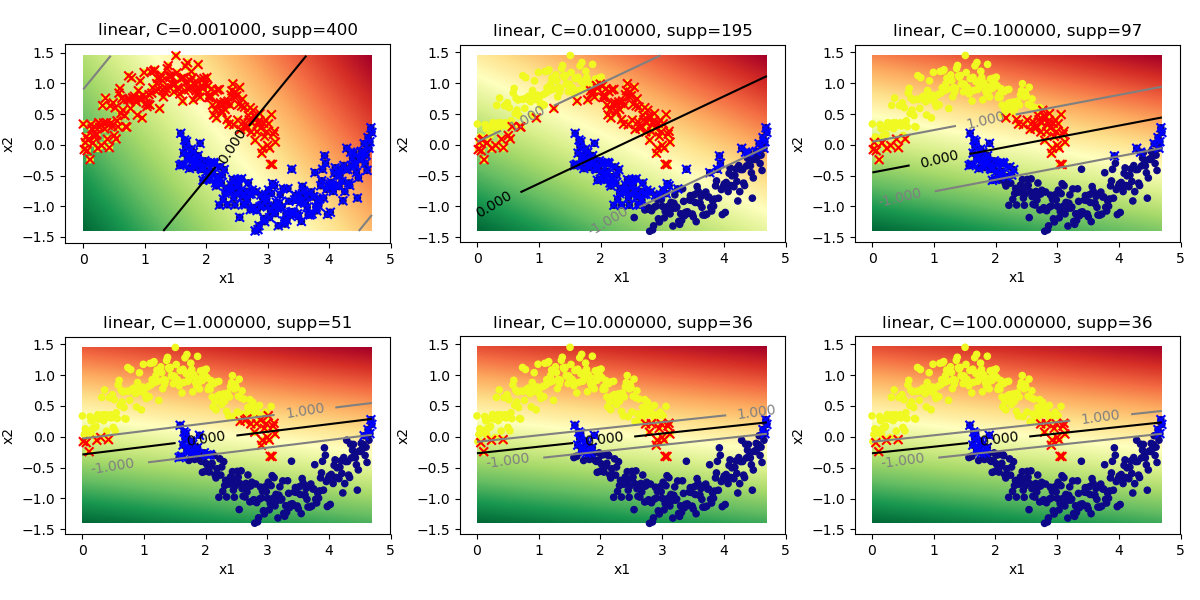

In [14]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C, kernel='linear').fit(dataset.loc[:,'x1':'x2'], dataset.t)
    plot_prediction(svc, 'linear, C=%f'%C,ax=ax)
plt.tight_layout()

Now we move to a QUADRATIC kernel (polynomial of degree 2); the kernel has the form:

$k(x,y) = (\lt x,y\gt + coef0)^{degree}$

 quadratic kernel, C=1 (cost parameter)

In [15]:
svc = SVC(C=1, kernel='poly',degree=2,coef0=1)
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [21 22]


<IPython.core.display.Javascript object>


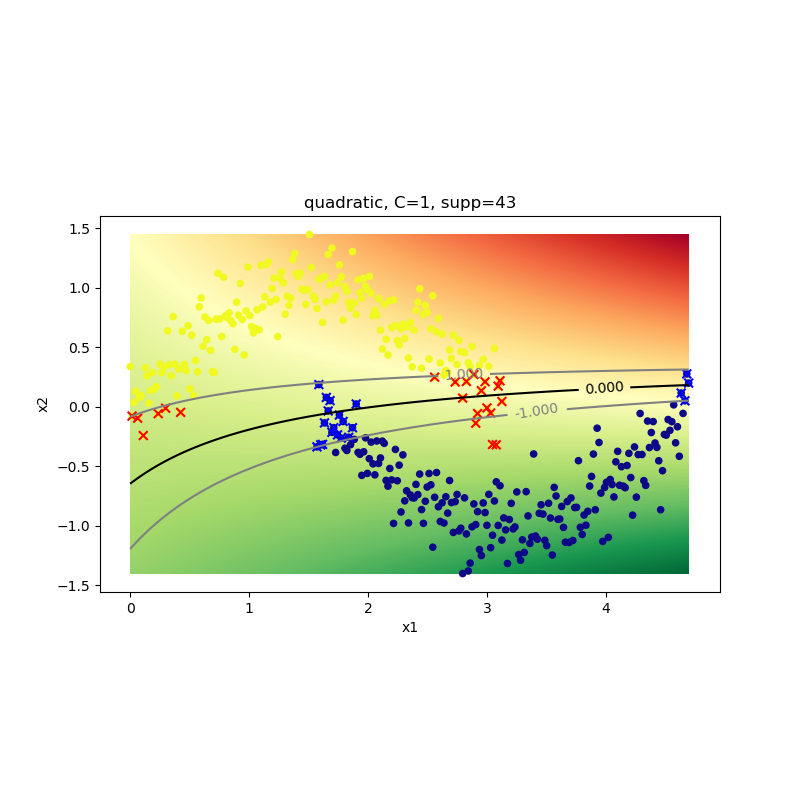

In [16]:
plot_prediction(svc, 'quadratic, C=1')

notice that neither the OSH or the margins are linear (they are quadratic); they are linear in the feature space
 in the previous linear kernel, both spaces coincide

Let's put it together directly, for 6 values of C:

<IPython.core.display.Javascript object>


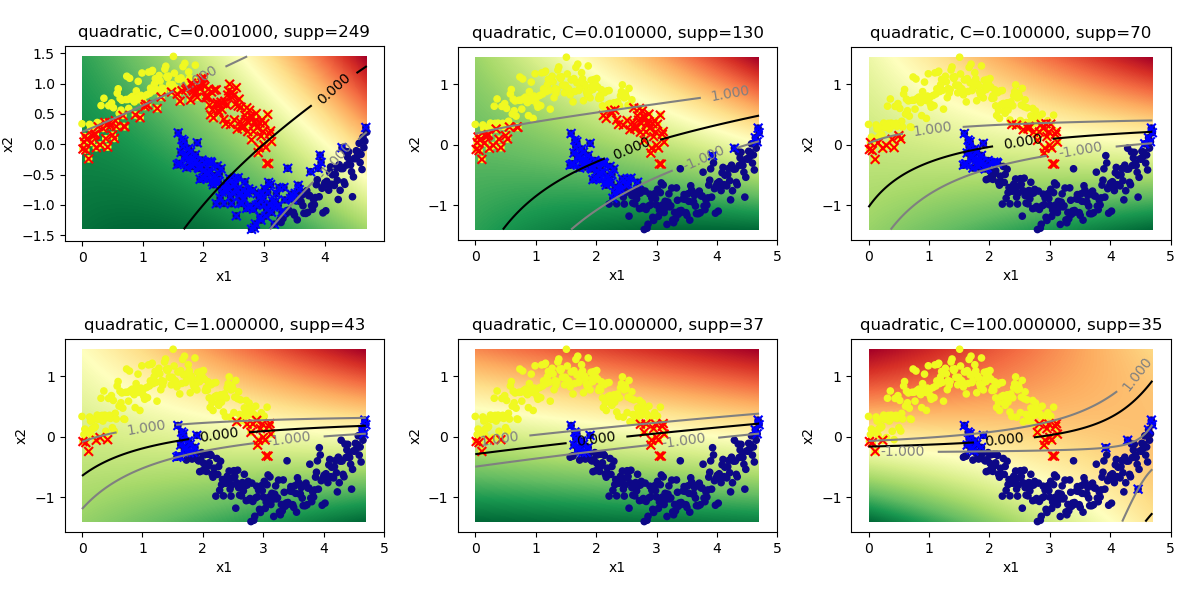

In [17]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C, kernel='poly',degree=2,coef0=1).fit(dataset.loc[:,'x1':'x2'], dataset.t)
    plot_prediction(svc, 'quadratic, C=%f'%C,ax=ax)
plt.tight_layout()

Now we move to a CUBIC kernel (polynomial of degree 3); the kernel has the form:

$k(x,y) = (\lt x,y \gt + coef0)^{degree}$

 cubic kernel, C=1 (cost parameter)

In [18]:
svc = SVC(C=1, kernel='poly',degree=3,coef0=1)
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [16 17]


<IPython.core.display.Javascript object>


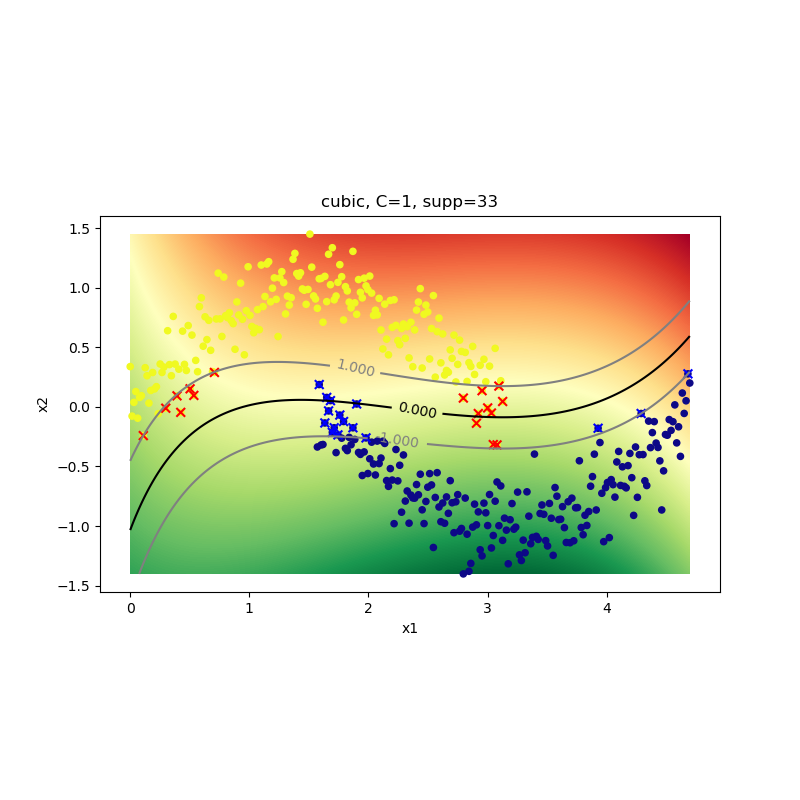

In [19]:
plot_prediction(svc, 'cubic, C=1')

 notice that neither the OSH or the margins are linear (they are now cubic); they are linear in the feature space
 this choice seems much better, given the structure of the classes

Let's put it together directly, for 6 values of C:

<IPython.core.display.Javascript object>


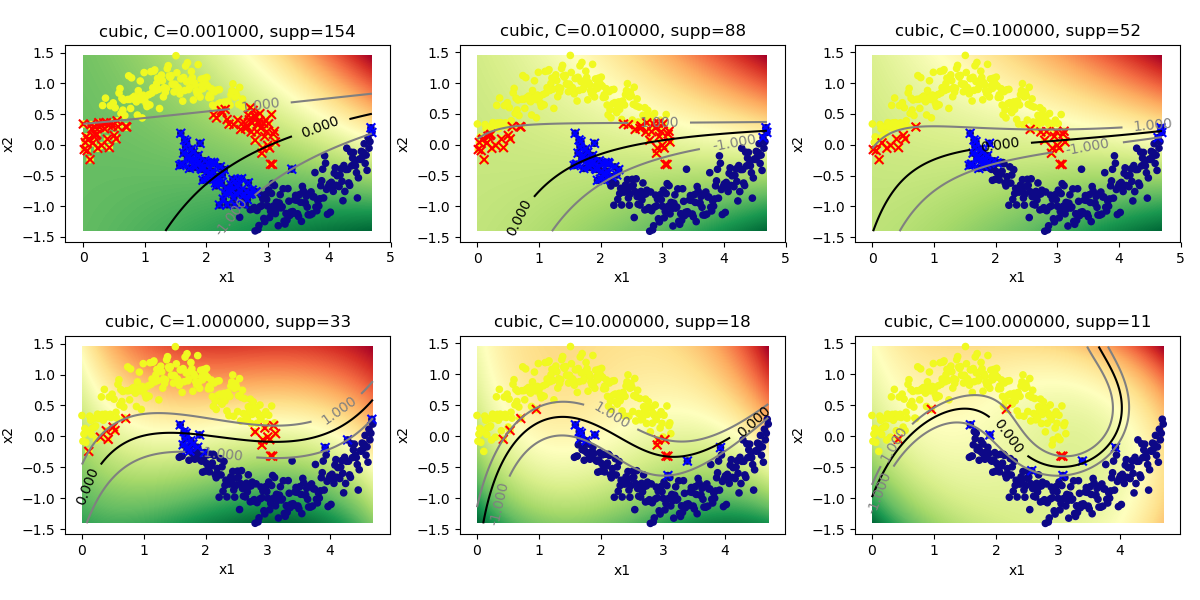

In [20]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C, kernel='poly',degree=3,coef0=1).fit(dataset.loc[:,'x1':'x2'], dataset.t)
    plot_prediction(svc, 'cubic, C=%f'%C,ax=ax)
plt.tight_layout()

Finally we use the Gaussian RBF kernel (polynomial of infinite degree; the kernel has the form:

$k(x,y) = exp(-gamma·||x - y||^2)$

RBF kernel, C=1 (cost parameter)

In [21]:
svc = SVC(C=1, kernel='rbf',gamma=0.5)
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [16 15]


<IPython.core.display.Javascript object>


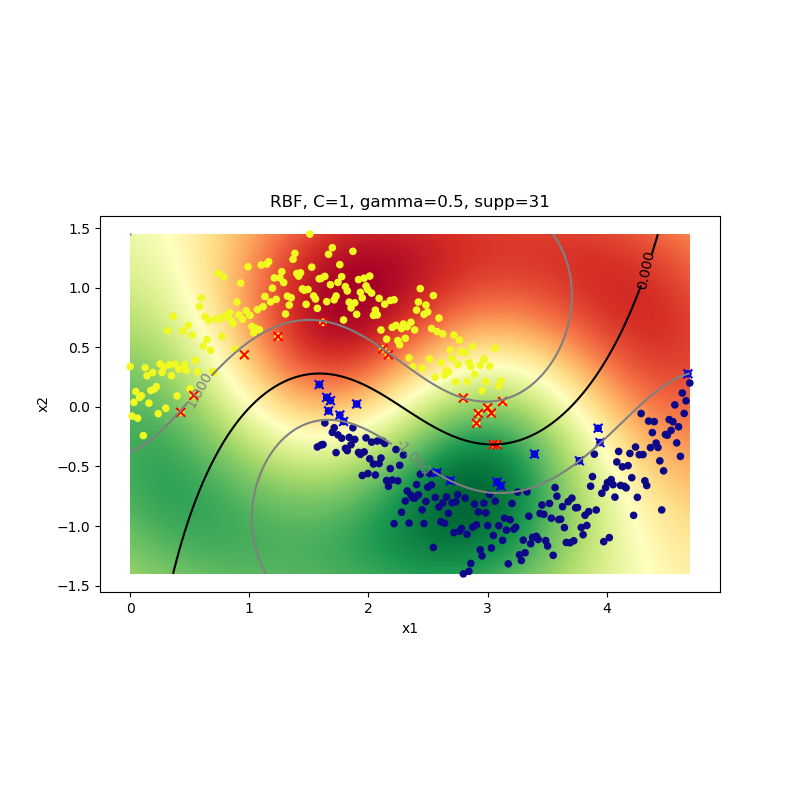

In [22]:
plot_prediction(svc, 'RBF, C=1, gamma=0.5')

 Let's put it together directly, for 6 values of C, holding gamma constant = 0.5:

<IPython.core.display.Javascript object>


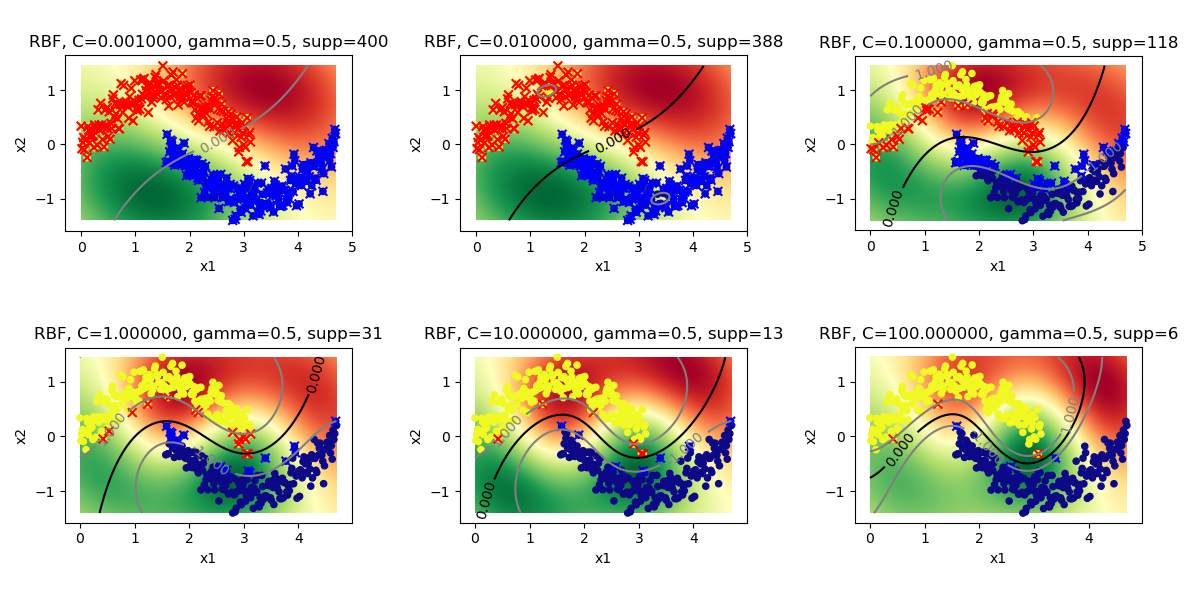

In [23]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C,  kernel='rbf',gamma=0.5).fit(dataset.loc[:,'x1':'x2'], dataset.t)
    plot_prediction(svc, 'RBF, C=%f, gamma=0.5'%C,ax=ax)
plt.tight_layout()

 Now for 8 values of gamma, holding C constant = 1:

<IPython.core.display.Javascript object>


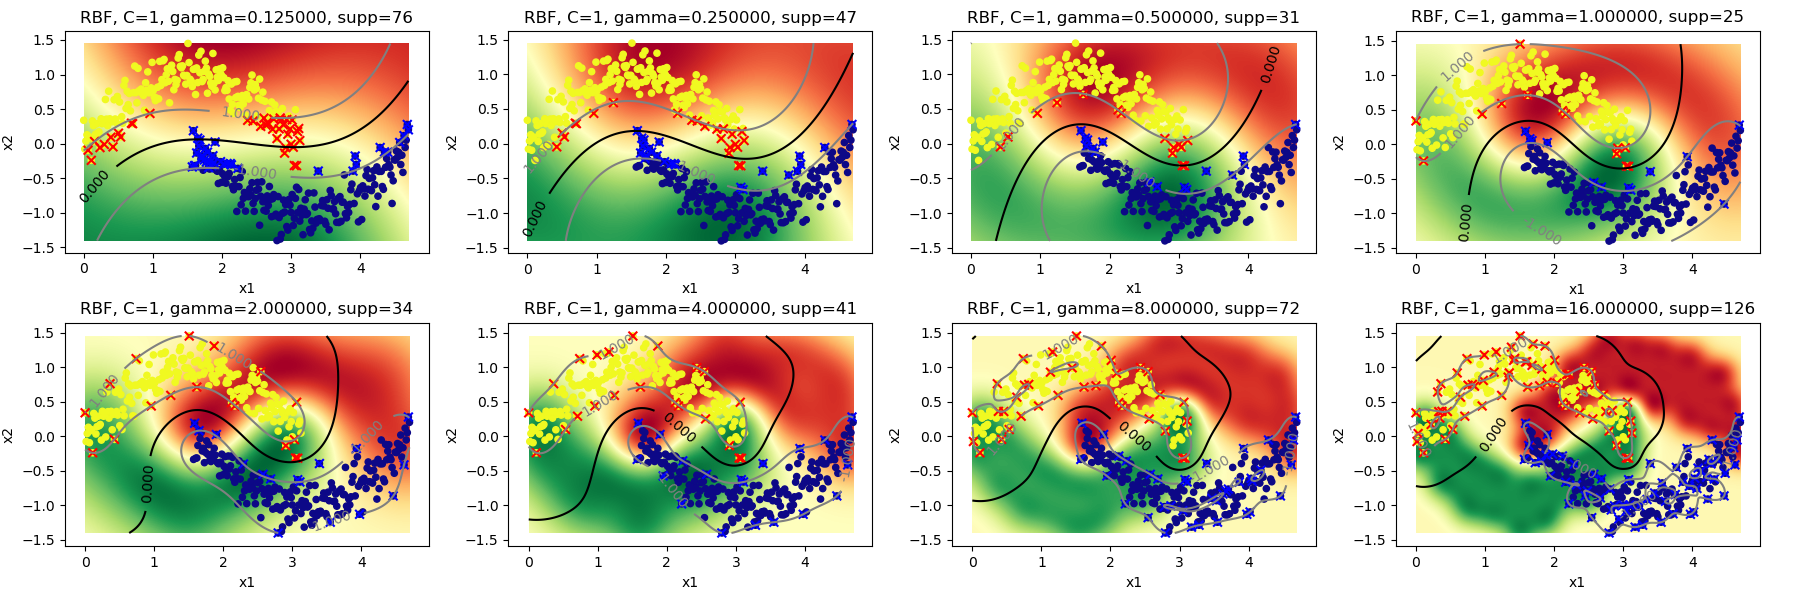

In [24]:
fig, ax = plt.subplots(2,4,figsize=(18,6))
for gamma, ax in zip(2**np.linspace(-3,4,8),ax.ravel()):
    svc = SVC(C=1,  kernel='rbf',gamma=gamma).fit(dataset.loc[:,'x1':'x2'], dataset.t)
    plot_prediction(svc, 'RBF, C=1, gamma=%f'%gamma,ax=ax)
plt.tight_layout()

 In practice we should optimize both (C,gamma) at the same time

 How? Using cross-validation or trying to get "good" estimates analyzing the data

 Now we define a utility function for performing k-fold CV: a typical choice is k=10

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score

k = 10 

In [26]:
def train_svm_kCV(C,  k, kCV=10, params={'kernel':'linear'}):
    merr = 0.0
    for i in range(kCV):
        cv = KFold(n_splits=k)
        for tr_ind,ts_ind in cv.split(dataset):
            svc = SVC(C=C, **params).fit(dataset.iloc[tr_ind,[0,1]], dataset.t.iloc[tr_ind])
            pred = svc.predict(dataset.iloc[ts_ind,[0,1]])
            merr += (1-accuracy_score(dataset.t.iloc[ts_ind],pred))
    return merr/(kCV*k)*100
            

In [27]:
C = 10

VA_error_linear = train_svm_kCV (C=C, k=10, params={'kernel':'linear'})
VA_error_linear

17.749999999999996

procedure is to choose the model with the lowest CV error and then refit it with the whole learning data,
 then use it to predict the test set; we will do this at the end

 Fit an SVM with quadratic kernel 

In [28]:
VA_error_poly_2 = train_svm_kCV (C=C, k=10, params={'kernel':'poly', 'degree':2,'coef0':1})
VA_error_poly_2

25.250000000000007

 Fit an SVM with cubic kernel

In [29]:
VA_error_poly_3 = train_svm_kCV (C=C, k=10, params={'kernel':'poly', 'degree':3,'coef0':1})
VA_error_poly_3

6.7500000000000036

In [30]:
VA_error_rbf = train_svm_kCV (C=C, k=10, params={'kernel':'rbf'})
VA_error_rbf

1.25

 Now in a real scenario we should choose the model with the lowest CV error
 which in this case is the RBF (we get a very low CV error because this problem is easy for a SVM)

 so we choose RBF and C=1 and refit the model in the whole training set (no CV)

In [31]:
svc = SVC(C=1,  kernel='rbf').fit(dataset.loc[:,'x1':'x2'], dataset.t)

 and make it predict a test set:

 let's generate the test data

In [32]:
dataset_test = make_sinusoidals (1000)

 and have a look at it

In [33]:
dataset_test.describe()

,x1,x2,t
count,2000.000000,2000.000000,2000.00000
mean,2.354624,0.005250,0.00000
std,1.200015,0.730382,1.00025
min,0.000000,-1.570369,-1.00000
25%,1.570011,-0.653295,-1.00000
50%,2.354624,0.002977,0.00000
75%,3.139236,0.687760,1.00000
max,4.709247,1.523076,1.00000


<IPython.core.display.Javascript object>


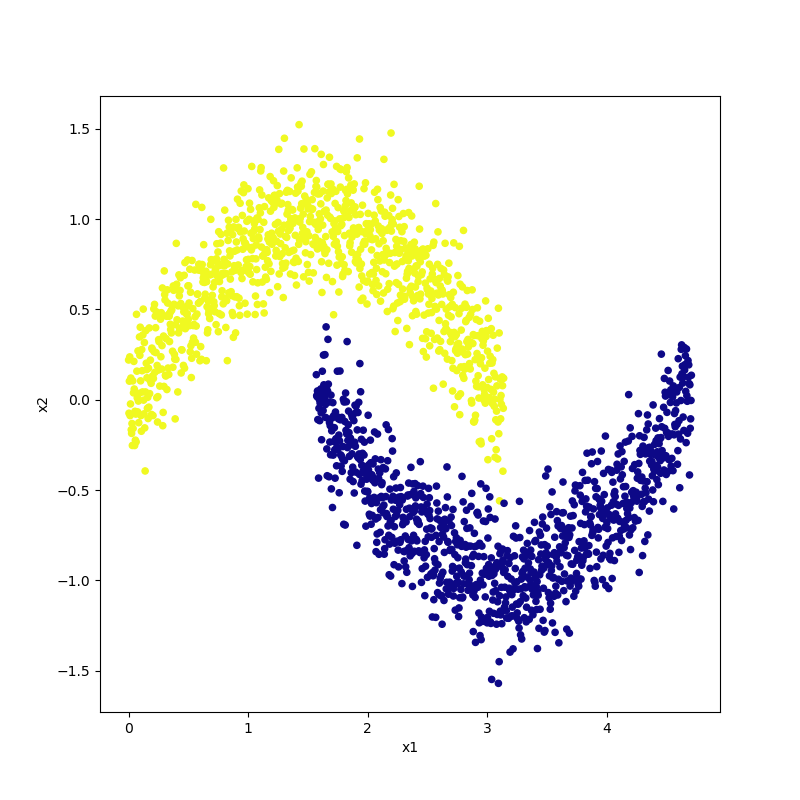

In [34]:
dataset_test.plot.scatter(x='x1', y='x2', c='t', colormap='plasma',figsize=(8,8),colorbar=False);

In [35]:
pred = svc.predict(dataset_test.loc[:,'x1':'x2']) 
df_tr=pd.DataFrame(confusion_matrix(dataset_test.t, pred), index=['-1','1'], columns=['-1','1'])
df_tr
(1-accuracy_score(dataset_test.t, pred))*100

,-1,1
-1,996,4
1,5,995


0.44999999999999485

 In a real setting we should also optimize the value of C, again with CV; all this can be done
 very conveniently using GridSearchCV to do automatic grid-search (very much as we did in the last
 laboratory for nnet)

 other packages provide with heuristic methods to estimate the gamma in the RBF kernel (see below)

[Here](https://dash-gallery.plotly.host/dash-svm) you can find  an interactive tool that allows to play with SVM

***

## Playing with the SVM for regression and 1D data

Now we do regression; we have an extra parameter: the 'epsilon', which controls the width of the 
epsilon-insensitive tube (in feature space)

In [36]:
A=20

 a really nice-looking function

<IPython.core.display.Javascript object>


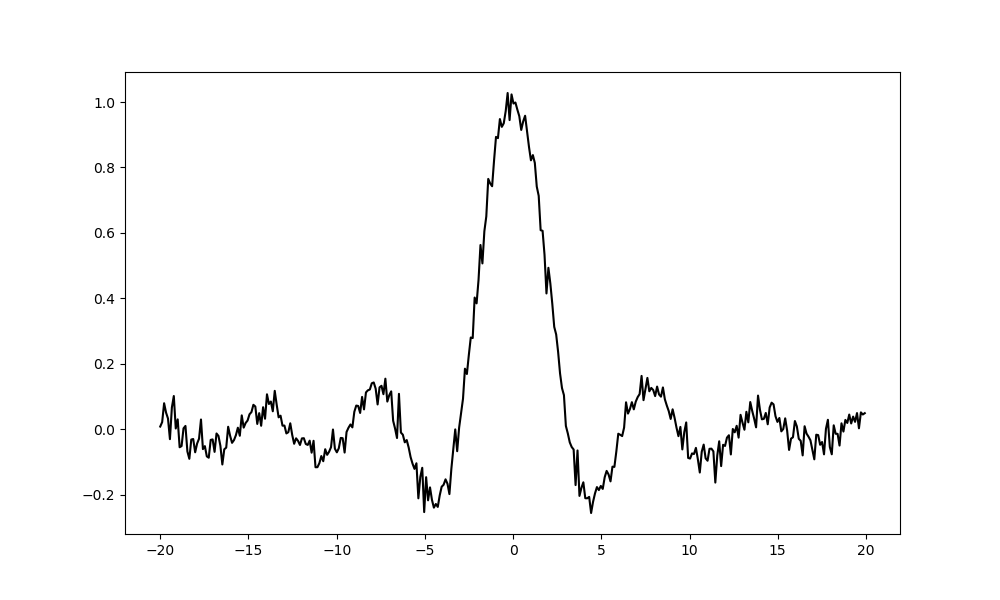

In [37]:
x = np.arange(-A,A,0.11)
y = (np.sin(x)/x) + normal(scale=0.03,size=len(x))
x = np.array(x).reshape(-1, 1)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-');

With this choice of the 'epsilon', 'gamma' and C parameters, the SVM underfits the data (blue line) 

<IPython.core.display.Javascript object>


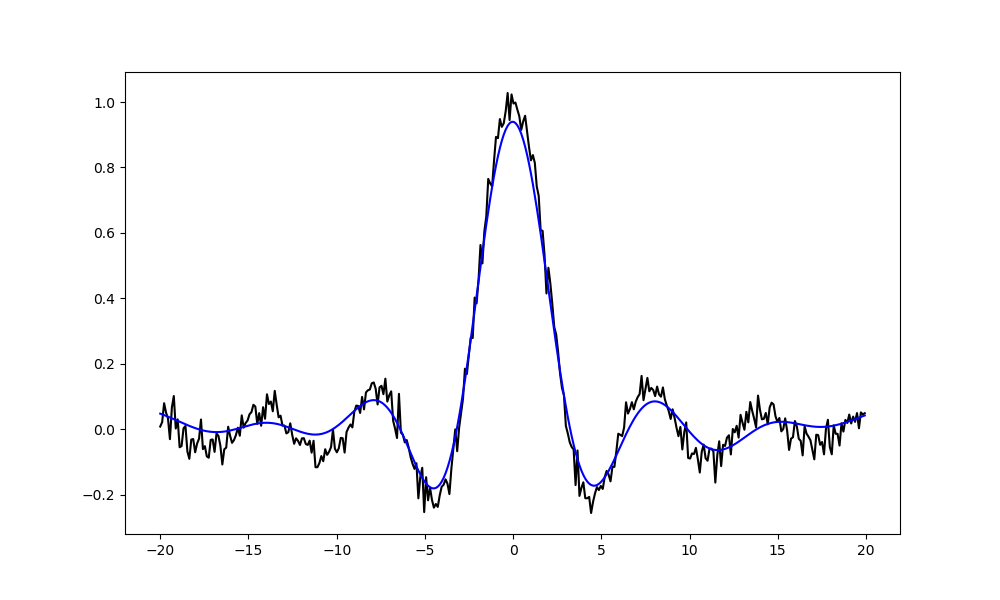

In [38]:
from sklearn.svm import SVR

svr = SVR(epsilon=0.1,gamma=0.1).fit(x,y)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-')
plt.plot(x,svr.predict(x),'b-');

With this choice of the 'epsilon', 'gamma' and C parameters, the SVM overfits the data (green line)

<IPython.core.display.Javascript object>


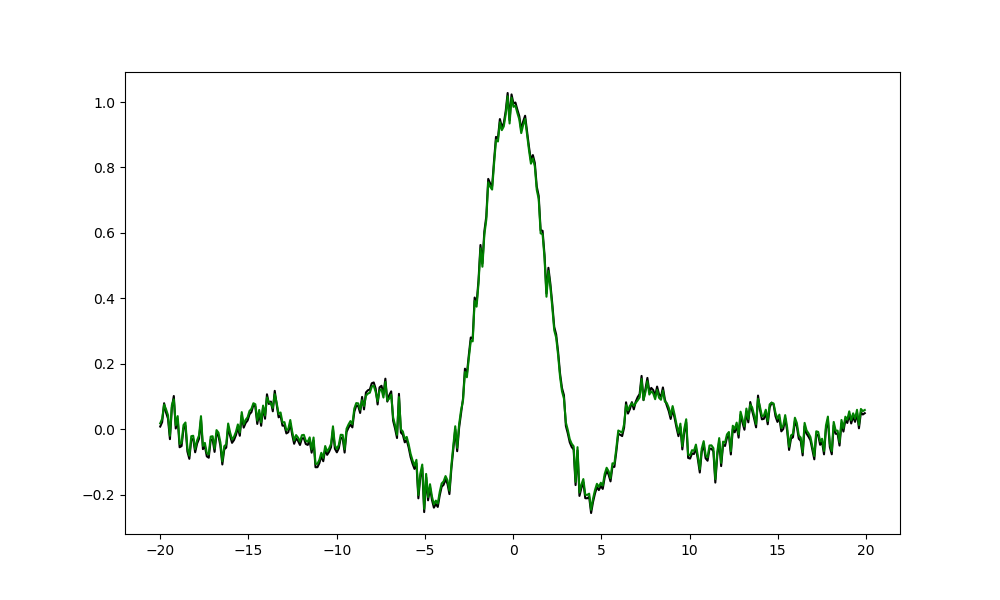

In [39]:
svr = SVR(epsilon=0.01,gamma=200, C=100).fit(x,y)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-')
plt.plot(x,svr.predict(x),'g-');

With this choice of the 'epsilon', 'gamma' and C parameters, the SVM has a very decent fit (red line)

<IPython.core.display.Javascript object>


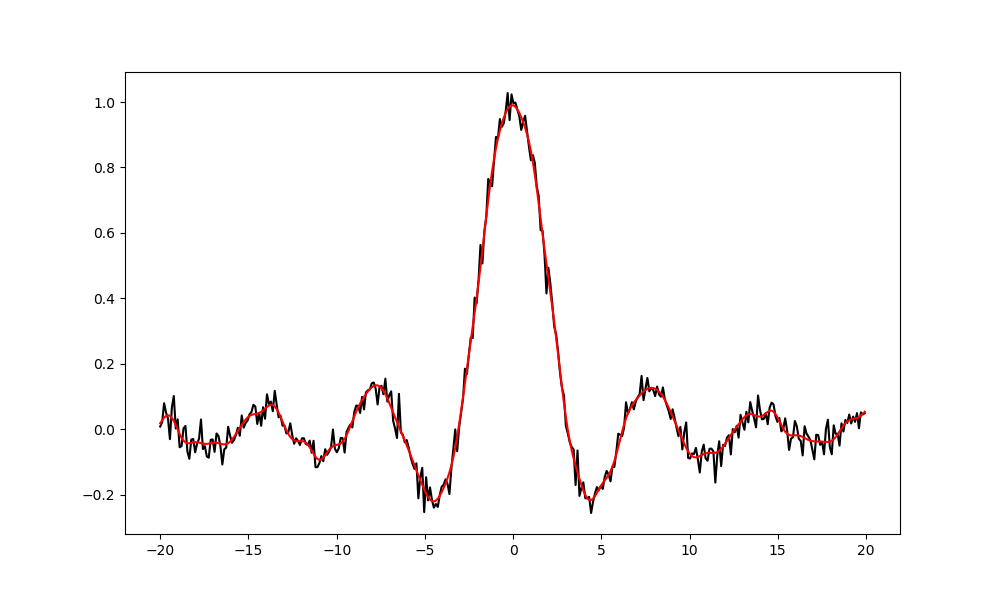

In [40]:
svr = SVR(epsilon=0.01,gamma=1).fit(x,y)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-')
plt.plot(x,svr.predict(x),'r-');